# Supervised learning with PyTorch
> Harrison B. Prosper 2021

## Introduction
In supervised learning a model is trained (that is, fitted) to data which, ideally, are unambiguously labeled. Each data instance consists of __targets__ and __inputs__, the latter sometimes referred to as __feature vectors__. 
The inputs could be, for example, 3 matrices of pixel values for an RGB image or financial data on a bank customer. The task could be the __classification__ of images in the first case or the classification of customers into credit risk categories in the other. Or, the task may be to map input data to an estimate of a quantity of interest; that is, one may wish to perform a __regression__. 

In this notebook, we classify data into two classes: one labeled with the __target__ $\color{blue}{y = 1}$ and the other labeled with the target $\color{blue}{y = 0}$. Each data instance to be classified is characterized by inputs $\mathbf{x}$.  The data set is $T = \{(y_i, \mathbf{x}_i ) \}$. 

__Fundamental assumption__: the data are drawn from a joint probability density function (or, for discrete data, probability mass function), $p(y, \mathbf{x})$.

## Model
We'll use the model 

$$f(\mathbf{x}, \theta) = \mbox{sigmoid}(\, b_2 + \mathbf{w}_2 \, \mbox{relu}(\,\mathbf{b}_1 + \mathbf{w}_1 \, \mbox{relu}(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}) \, )\,),$$

where $\mathbf{b}$ and $\mathbf{w}$ (the biases and weights) are the parameters $\theta$ of the model and $\mbox{relu}(x)$ is a function applied to every element $x_i$ of its tensor argument (i.e., applied element-wise) defined by

\begin{align*}
\mbox{relu}(x) & = \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}

The functions $\mbox{sigmoid}(x)$ and $\mbox{relu}(x)$ are implemented in the PyTorch functions
torch.nn.__Sigmoid__() and torch.nn.__ReLU__(), respectively. In this tutorial, $b_1$ is a scalar since we have just one output. (Note, however, the PyTorch sublety described in the *train* function below regarding the output of the object *model*.)



## Loss function
Typically, a machine learning model is fitted to the training data by minimizing a suitably defined function, which in the statistics literature is referred to as the __empirical risk__. (Fitting models to data is called learning by the machine learning community.) The empirical risk is a Monte Carlo approximation of the __risk functional__, given by 

\begin{align*}
    R[f] &= \int \cdots \int L(y, \, f(\mathbf{x}, \theta)) \, 
    p(y, \, \mathbf{x}) \, dy \, d\mathbf{x},
\end{align*}

where $L(y, \, f)$ is called the __loss function__ and measures how much one loses if the output of the parameterized function $f(x, \theta)$ differs from the __target__ $y$. $\color{blue}{\rm Note}$: In the machine learning world, the empirical risk is often referred to as the loss function, when what is really meant is the average loss function. 

__Important Note__: In order for the risk functional $R[f]$ to reach its minimum, defined by variations of $f$ that yield the condition $\delta R = 0$ $\forall \, x$, the function $f$ must be sufficiently flexible. If the latter condition is satisfied, then the mathematical quantity approximated by $f$ depends solely on the form of the loss function $L(y, \, f)$ and the probability distribution $p(y, \, x)$ of the training data. In particular, it does not depend on
    the details of the functon $f$ apart from its presumed flexibility. Of course, in practice, we do not minimize $R[f]$, but rather the empirical risk, which approximates it. Nevertheless, to the degree that a very large data set approximates an infinite one and to the degree that our minimizer is able to find a good approximation to the minimum,  it is as least as important to think about the form of the loss function $L(y, \, f)$ as it is to think about the form of the model. If we have two models of equal functional flexibility then, *a priori*, for the same loss function the models will approximate the same quantity. 

In [2]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

#  a function to save results
import joblib as jb

# pytorch
import torch

# pytorch neural network module
import torch.nn as nn

#  split data into a training set and a test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [3]:
# update fonts
FONTSIZE = 20
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE
        }
mp.rc('font', **font)
#mp.rc('xtick', labelsize='x-small')
#mp.rc('ytick', labelsize='x-small')
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd  = np.random.RandomState(seed)

### Some useful tensor operations

In [4]:
# Create a float tensor
a = torch.Tensor([[1,2], [3,4]])
print(a)

'''The capital T in Tensor makes all the difference.
Tensor makes an array of floats, while tensor makes an array too but infers the type'''

# Create an integer tensor, which we'll use for gathering  
# elements of the [2,2] tensor 'a' along its dim=1 
# (that is, horizontal) dimension.
i = torch.tensor([1,0])
print(i)

# Note that since we're gathering along the dim=1 dimension
# of 'a' the tensor 'i' must be of the same shape as 'a'
# along dimensions other than dim=1, that is, along dim=0.
# By using view(-1,...) we make the dim=0 (vertical)
# dimension of 'i' the same length as the dim=0 dimension of 'a'.
b  = a.gather(dim=1, index=i.view(-1, 1))
print(b)

# Now we get rid of extraneous dimensions.
# Compare tensors 'b' and 'c'. in 'b' there is only one 
# element per row along dim=1, so its shape is [2, 1]. 
# We are, therefore, free to squeeze away the dim=1 to
# arrive at a new tensor 'c' with shape [2,]
c = b.squeeze()
print(c)

tensor([[1., 2.],
        [3., 4.]])
tensor([1, 0])
tensor([[2.],
        [3.]])
tensor([2., 3.])


### Generate a balanced data set: $p(0) = p(1)$
  1. Generate data for $t = 0$
  1. Generate data for $t = 1$
  1. Concatenate data sets
  1. Randomly shuffle rows

In [5]:
STDV   = 0.5
NDATA  = 15000

# ---------
# t = 0
# ---------
# constants
MU00   = np.array([-1.0, 1.0])     # means
COV00  = np.array([[STDV, 0.0],    # covariance matrix
                   [ 0.0, STDV]])

MU01   = np.array([1.0, -1.0])
COV01  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])
 
# density
def px0(x):
    p \
    = st.multivariate_normal.pdf(x, MU00, COV00) \
    + st.multivariate_normal.pdf(x, MU01, COV01)
    return p / 2

# data generation
def generate0():
    xy = st.multivariate_normal.rvs(MU00, COV00, NDATA).tolist()
    z  = st.multivariate_normal.rvs(MU01, COV01, NDATA).tolist()
    xy.extend(z)
    return np.array(xy)

# ---------
# t = 1
# ---------
# constants
MU10   = np.array([-1.0, -1.0])
COV10  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

MU11   = np.array([1.0, 1.0])
COV11  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

# density
def px1(x):
    p \
    = st.multivariate_normal.pdf(x, MU10, COV10) \
    + st.multivariate_normal.pdf(x, MU11, COV11)
    return p / 2

# data generation
def generate1():
    xy = st.multivariate_normal.rvs(MU10, COV10, NDATA).tolist()
    z  = st.multivariate_normal.rvs(MU11, COV11, NDATA).tolist()
    xy.extend(z)
    return np.array(xy)

# p(1|x)
def p1x(x):
    return px1(x) / ( px1(x) + px0(x) )

def generate(target):
    d  = generate0() if target < 0.5 else generate1()
    N  = len(d)
    Y  = np.zeros(N) if target < 0.5 else np.ones(N)
    X1 = [x1 for x1, x2 in d]
    X2 = [x2 for x1, x2 in d]
    T  = pd.DataFrame({'y': Y, 'x1': X1, 'x2': X2})
    return T

In [6]:
b = generate(0)
s = generate(1)
d = b.append(s)

# frac=1 => all rows
# reset_index(drop=True) => drop original indices and create new ones
data = d.sample(frac=1).reset_index(drop=True)
print('number of instances: %d' % len(data))
data[:5]

number of instances: 60000


,y,x1,x2
0,0.0,0.548813,-0.944814
1,0.0,-2.061580,1.720183
2,1.0,-0.909111,-0.590025
3,1.0,-0.551250,-1.246777
4,0.0,0.864918,-1.259868


In [23]:
def plot_data(df, N=8000):
    
    # divide data into 
    # those with target == 1 and 
    # those with target == 0.
    sig = df[df.y > 0.5][:N]
    bkg = df[df.y < 0.5][:N]
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.set_xlabel('$x_1$', fontsize=FONTSIZE)
    ax.set_ylabel('$x_2$', fontsize=FONTSIZE)
    
    ax.set_xlim((-4, 4))
    ax.set_ylim((-4, 4))
    
    ax.scatter(sig.x1, sig.x2, c='b', s=1, alpha=0.5, label='$y = 1$')
    ax.scatter(bkg.x1, bkg.x2, c='r', s=1, alpha=0.5, label='$y = 0$')
    
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='lower left')

    plt.show()

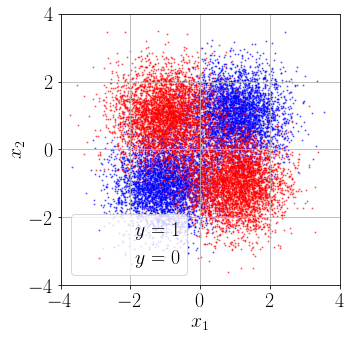

In [24]:
plot_data(data)

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [25]:
# Fraction of the data assigned as test data
fraction = 1/6

# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 1/10
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train set size:         45000
validation set size:     5000
test set size:          10000


### Split data into targets and inputs
  Since the inputs in this example are labeled $x$ and $y$, we'll use the $t$ for the targets to avoid confusion.

In [64]:
def split_y_x(df, inputs=['x1', 'x2']):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    y = np.array(df.y).astype(np.int64)
    x = np.array(df[inputs]).astype(np.float32)
    return (y, x)

train_y, train_x = split_y_x(train_data)
valid_y, valid_x = split_y_x(valid_data)
test_y,  test_x  = split_y_x(test_data)

In [66]:
train_y

array([1, 0, 0, ..., 1, 0, 0])

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined as

\begin{align}
R_N(\theta) & = \frac{1}{N}\sum_{n=1}^N L(y_n, f_n),
\end{align}

where 

\begin{align}
    f_n & \equiv f(\mathbf{x}_n, \theta),\\ \\ \textrm{and} \\
    L(y, f) &= 
\begin{cases}
    -\ln f, & \text{if } y == 1\\
    -\ln (1-f)             & \text{otherwise}.
\end{cases}
\end{align}

The empirical risk $R_N$ approximates the __risk functional__

\begin{align}
R[f] & = \int \cdots \int \, p(y, \mathbf{x}) \, L(y, f(\mathbf{x}, \theta)) \, dy \, d\mathbf{x},
\end{align}

which is a __functional__ of the model $f$. The quantity $p(y, \mathbf{x}) \, dy\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (y_n, \mathbf{x}_n), n = 1,\cdots, N \}$ is presumed to have been drawn. 


__PyTorch__ has, of course, a cross entropy function, but let's implement it explicitly (for a 2-class problem).

In [49]:
def average_loss(y, f):
    # y: target
    # f: model output
    #
    # Note: y and f must be of the same shape. 
    #
    # The following implements a ternary operator:
    #    do-this if condition-is-true else do-that
    #losses = torch.where(y > 0.5, torch.log(f), torch.log(1-f)) #is this a mistake?
    losses = torch.where(y == 1, torch.log(f), torch.log(1-f))
    return -torch.mean(losses) 

In [28]:
def accuracy(y, f):
    # note: y and f must be of the same shape. 
    # count how many times the predicted target, p, matches 
    # the true target, y. then convert to a fraction.
    f = f.reshape(y.shape)
    p = (f > 0.5).long()   # convert to long ints
    a = (p == y).float()   # convert to floats
    return float(torch.mean(a))

### Validation function

In [29]:
def validate(model, targets, inputs):
    # Make sure to set evaluation mode so that training specific
    # operations such as dropout are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        x = torch.from_numpy(inputs)
        y = torch.from_numpy(targets)
        f = model(x)      # predict probabilities p(1|x)
    return accuracy(y, f)

### Return a (random) batch of data from the training set

In [30]:
def get_batch(y, x, batch_size):
    # The numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = rnd.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_y = y[rows]
    return (batch_y, batch_x)

### Function to execute training loop

In [31]:
def train(model,            # ML model
          optimizer,        # optimizer..duh!
          avloss,           # empirical risk (average loss)
          getbatch,         # function to get a batch of data
          train_y, train_x, # training data
          valid_y, valid_x, # validation data
          batch_size, 
          n_iterations, step=10):
    
    xx   = []    # cache for iteration number
    yy_t = []    # cache for accuracy computed on training data
    yy_v = []    # cache for accuracy computed on validation data
    n    = len(valid_x)
    
    # Set mode to training so that training 
    # specific operations such as dropout are enabled.
    model.train()
    
    print('Accuracy')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # Training loop
    for ii in range(n_iterations):

        # Get a random sample (a batch) of data (as numpy arrays)
        batch_y, batch_x = getbatch(train_y, train_x, batch_size)
        
        # Convert the numpy arrays batch_y and batch_x, to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature:
        with torch.no_grad(): 
            x = torch.from_numpy(batch_x)
            y = torch.from_numpy(batch_y)     

        # Compute the output of the model for the batch of data 'x'
        # making sure that the shape of outputs is the same as 
        # the shape of targets 'y'.
        outputs = model(x).reshape(y.shape)
        
        # Compute a noisy approximation to the average loss at the
        # current point in the parameter space. Noisy gradients 
        # increase the chance that the optimizer can escape local
        # minima.
        empirical_risk = avloss(y, outputs)
        
        # Use automatic differentiation to compute the
        # noisy approximation of the local gradient.
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # Finally, advance one step in the direction of steepest 
        # descent using the noisy local gradient. 
        optimizer.step()            # move a single step
        
        # print out some "I'm alive info"
        if ii % step == 0:
            # Compute a validation measure using the model 
            # given its current parameters.
            # Make training data the same size as the validation data.
            acc_t = validate(model, train_y[:n], train_x[:n]) 
            acc_v = validate(model, valid_y, valid_x)
            
            # print on same line
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), 
                  end='')
        
            # Update cache
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

### Make a few plots
__matplotlib__ has two graphics systems:
  1. function-based and
  2. object-based. 
  
The function below (plot_accuracy) illustrates the function-based system, while plot_empirical_risk illustrates the object-based system.

In [32]:
def plot_accuracy(traces, gfile='fig_accuracy.png'):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 5))
    
    # adjust y limits
    plt.ylim((0, 1))
    plt.xlim((0, xx[-1]))
    
    plt.xlabel('Iterations', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    
    plt.title('Training and Validation Accuracy', 
              color='blue', fontsize=16)
    
    plt.plot(xx, yy_t, 'b', label='Training')
    plt.plot(xx, yy_v, 'r', label='Validation')

    plt.legend(loc='lower right')
    
    plt.grid(True, which="both", linestyle='-')

    plt.tight_layout()
    plt.savefig(gfile)
    plt.show()

In [33]:
def plot_empirical_risk(xx, yy_t, yy_v, 
                        gfile='fig_average_loss.png'):
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss function", fontsize=16)
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    
    plt.savefig(gfile)
    plt.show()

### Define ML model $f(\mathbf{x}, \theta)$

In [34]:
# The sequential class is often sufficient for simple models.
model = nn.Sequential(nn.Linear(2,   150), nn.ReLU(),
                      nn.Linear(150, 150), nn.ReLU(),
                      nn.Linear(150,   1), nn.Sigmoid())

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=150, bias=True)
  (1): ReLU()
  (2): Linear(in_features=150, out_features=150, bias=True)
  (3): ReLU()
  (4): Linear(in_features=150, out_features=1, bias=True)
  (5): Sigmoid()
)


### Train!

Instantiate an optimizer, then train

Recall, that every step in the iteration is given by

$$\theta_\mbox{new} = \theta_\mbox{current} - \eta \, \nabla R_M,$$

where $\eta$ is called the *learning rate*. The so-called learning rate $\eta$ should be small and we gradually decrease it. Why?

In [50]:
n_batch      =    50 # batch size
n_iterations = 20001 # number of iterations

# We'll use the Stochastic Gradient Descent optimizer
# with:
learning_rate= 1.e-3

optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate, 
                            weight_decay=1.e-5)

traces    = train(model, optimizer, average_loss, get_batch,
                  train_y, train_x, 
                  valid_y, valid_x,
                  n_batch, n_iterations, step=10)

Accuracy
 iteration	 train-set	 valid-set
     20000	    0.8460	    0.8586

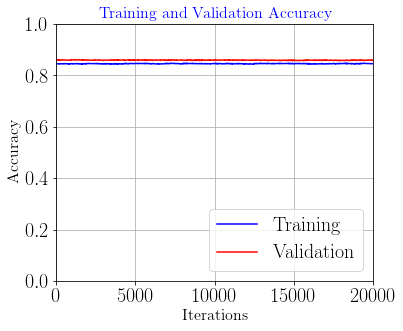

In [42]:
plot_accuracy(traces)

### Compute $f(x, \theta^*) \approx p(y = 1 | x)$ on test data

In [51]:
def compute_prob(model, xx):
    
    model.eval() # set to evaluation mode
    
    # convert from numpy array to a torch tensor of type float
    x = torch.from_numpy(xx).float()

    # compute p(1|x)
    p = model(x)
    
    # squeeze() removes extraneous dimensions ([-1, 1] => [-1])
    p = p.squeeze()

    # detach().numpy() converts back to a numpy array
    p = p.detach().numpy()
    return p

In [52]:
p = compute_prob(model, test_x)

### Plot distribution of model outputs

In [53]:
def plot_distributions(y, p):
    ps = p[y > 0.5] # probabilities for class with y == 1
    pb = p[y < 0.5] # probabilities for class with y == 0
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlim(0, 1)

    ax.hist(ps, bins=50, color='b',
            histtype='stepfilled',
            alpha=0.3, label='$y = 1$')
    
    ax.hist(pb, bins=50, color='r',
            histtype='stepfilled',
            alpha=0.3, label='$y = 0$')
    
    ax.set_xlabel('$p(y=1|x)$', fontsize=FONTSIZE)
    ax.legend(loc='upper right')

    plt.show()

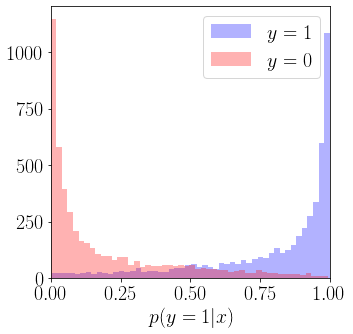

In [54]:
plot_distributions(test_y, p)

### Plot Receiver Operating Characteristic (ROC) curve

Also compute the area under the curve (AOC). In this example, the true densities of the two classes are known so we can compute the expected ROC and AUC.

In [55]:
def plot_roc_curve(y, p, p_t):
    
    # compute fraction of class instances that pass
    # different thresholds for y = 0 and y = 1 classes.
    f0, f1, _ = roc_curve(y, p)
    roc_auc   = auc(f0, f1)   # compute area under curve

    # compute ROC and AUC using the true densities
    f0_t, f1_t, _ = roc_curve(y, p_t)
    roc_auc_t     = auc(f0_t, f1_t)
    
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    ax  = fig.add_subplot(1,1,1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel(r'fraction$(t=0)$', fontsize=18)
    ax.set_ylabel(r'fraction$(t=1)$', fontsize=18)
    
    ax.plot(f0, f1, color='red',
            lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    ax.plot(f0_t, f1_t, color='black',
            lw=1, label='True ROC curve, AUC = %0.2f)' % roc_auc_t)
    
    ax.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
    
    ax.legend(loc="lower right", fontsize=14)
    
    plt.savefig('fig_roc.png')
    plt.show()

In [56]:
p_t = p1x(test_x)

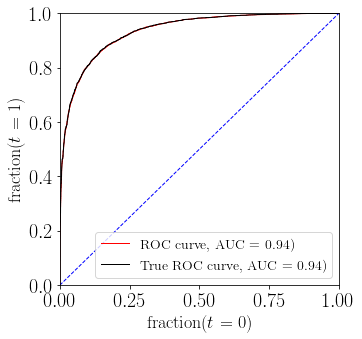

In [57]:
plot_roc_curve(test_y, p, p_t)

### Plot contours of $p(y = 1 | x)$

In [58]:
def plot_contours(model, df,
                  xmin=-3, xmax=3, ymin=-3, ymax=3, N=4000,
                  ftsize=FONTSIZE):
 
    # split data into "signal" and "background"
    sig = df[df.y > 0.5][:N]
    bkg = df[df.y < 0.5][:N]
    
    # create an empty figure
    fig = plt.figure(figsize=(8, 4))
    fig.tight_layout()

    # add two subplots to figure
    nrows, ncols = 1, 2
    ax1 = fig.add_subplot(nrows, ncols, 1) # subplot 1
    ax1.set_xlabel('$x_1$', fontsize=FONTSIZE)
    ax1.set_ylabel('$x_2$', fontsize=FONTSIZE)
    ax1.set_xlim([xmin, xmax])
    ax1.set_ylim([ymin, ymax])
    
    ax2 = fig.add_subplot(nrows, ncols, 2) # subplot 2
    ax2.set_xlabel('$x_1$', fontsize=FONTSIZE)
    ax2.set_xlim([xmin, xmax])
    ax2.set_ylim([ymin, ymax])
            
    # create a contour plot
    # 1. create a meshgrid
    # 2. compute model output at all mesh points
    nsteps = 200
    xdelta = float(xmax-xmin)/nsteps
    ydelta = float(ymax-ymin)/nsteps
    xx     = np.arange(xmin, xmax+xdelta, xdelta)
    yy     = np.arange(ymin, ymax+ydelta, ydelta)
    xx, yy = np.meshgrid(xx, yy)
    npoints= len(xx)
 
    # convert meshgrid into an (N, 2) numpy array
    xy  = np.array([[x, y] for x, y in zip(xx.flatten(), 
                                           yy.flatten())])

    # compute true class probabilities
    p_t = p1x(xy) # true prob.
    # ...then reshape to an (npoints x npoints) array
    zz_t= np.array(p_t).reshape((npoints, npoints))
    
    # compute model class probabilities
    p   = compute_prob(model, xy)
    zz  = np.array(p).reshape((npoints, npoints))

    # get fancy color maps
    cmap1 = plt.get_cmap('viridis')
    cmap2 = plt.get_cmap('Blues') 
    
    # plot p(1|x) as an image
    ax1.imshow(zz_t, origin='lower', aspect='auto', 
               extent=(xmin, xmax, ymin, ymax), 
               cmap=cmap1)

    # superimpose data
    ax1.scatter(sig.x1, sig.x2, c='b', s=1, alpha=0.5)
    ax1.scatter(bkg.x1, bkg.x2, c='r', s=1, alpha=0.5)
    ax1.set_title('True $p(y = 1|x_1, x_2)$', fontsize=18)
    
    # superimpose contours of constant p(1|x)
    step = 0.1
    mylevels = np.arange(0, 1, step)
    ax1.contour(xx, yy, zz_t, levels=mylevels, cmap=cmap2)
    
    # plot p(1|x) as an image
    ax2.imshow(zz, origin='lower', aspect='auto', 
               extent=(xmin, xmax, ymin, ymax), 
               cmap=cmap1)
    
    # superimpose data
    ax2.scatter(sig.x1, sig.x2, c='b', s=1, alpha=0.5)
    ax2.scatter(bkg.x1, bkg.x2, c='r', s=1, alpha=0.5)
    ax2.set_title('Approximation', fontsize=18)
    
    # superimpose contours
    ax2.contour(xx, yy, zz, levels=mylevels, cmap=cmap2)
        
    plt.savefig('fig_contours.png')
    plt.show()

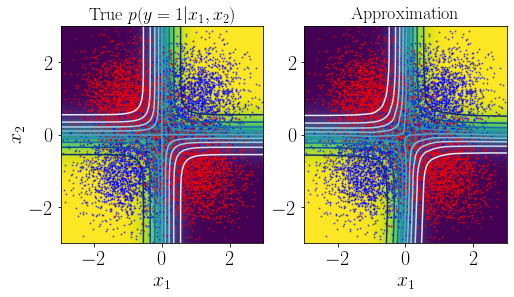

In [59]:
plot_contours(model, test_data)